<a href="https://colab.research.google.com/github/rezu98/colab/blob/main/STM%20by%20LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
######################################
### TOPIC MODELING OF FOMC MINUTES ###
######################################

### IMPORT LIBRARIES ###

import requests
import re
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import gensim
import gensim.corpora as corpora
from gensim import models
import matplotlib.pyplot as plt
import spacy
from pprint import pprint
from wordcloud import WordCloud
from mpl_toolkits import mplot3d
import re
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 64.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 84.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 32.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicor

In [2]:
nlp = spacy.load("en_core_web_sm")

# nlp = spacy.load("en_core_web_lg")
nlp.max_length = 1500000 # In case max_length is set to lower than this (ensure sufficient memory)

In [ ]:
### Define Dictionary by loughran and mcdonald(2019)

## loading master dictionary

def load_masterdictionary(file_path, print_flag=False, f_log=None, get_other=False):
    start_local = dt.datetime.now()
    # Setup dictionaries
    _master_dictionary = {}

    # Loop through words and load dictionaries
    with open(file_path, encoding="utf-8") as f:
        _total_documents = 0
        _md_header = f.readline()  # Consume header line
        print()
        for line in f:
            cols = line.rstrip('\n').split(',')
            word = cols[0].upper()  # Convert word to uppercase
            negative_value = int(cols[7])
            positive_value = int(cols[8])
            uncertainty_value = int(cols[9])
            _master_dictionary[word] = {'negative': negative_value, 'positive': positive_value, 'uncertainty': uncertainty_value}

    if print_flag:
        print('\r', end='')  # clear line
        print(f'\nMaster Dictionary loaded from file:\n  {file_path}\n')
        print(f'  master_dictionary has {len(_master_dictionary):,} words.\n')

    if get_other:
        return _master_dictionary, _md_header, _total_documents
    else:
        return _master_dictionary

In [40]:
### GRAB THE DOCUMENTS BY PARSING URLs ###

# Define URLs for the specific FOMC minutes
URLPath = r'https://www.federalreserve.gov/monetarypolicy/fomcminutes'
URLExt = r'.htm'

# List for FOMC minutes from 2007 onward
MinutesList = ['20071031', '20071211', # 2007 FOMC minutes (part-year on new URL format)
           '20080130', '20080318', '20080430', '20080625', '20080805', '20080916', '20081029', '20081216', # 2008 FOMC minutes
           '20090128', '20090318', '20090429', '20090624', '20090812', '20090923', '20091104', '20091216', # 2009 FOMC minutes
           '20100127', '20100316', '20100428', '20100623', '20100810', '20100921', '20101103', '20101214', # 2010 FOMC minutes
           '20110126', '20110315', '20110427', '20110622', '20110809', '20110921', '20111102', '20111213', # 2011 FOMC minutes
           '20120125', '20120313', '20120425', '20120620', '20120801', '20120913', '20121024', '20121212', # 2012 FOMC minutes
           '20130130', '20133020', '20130501', '20130619', '20130731', '20130918', '20131030', '20131218', # 2013 FOMC minutes
           '20140129', '20140319', '20140430', '20140618', '20140730', '20140917', '20141029', '20141217', # 2014 FOMC minutes
           '20150128', '20150318', '20150429', '20150617', '20150729', '20150917', '20151028', '20151216', # 2015 FOMC minutes
           '20160127', '20160316', '20160427', '20160615', '20160727', '20160921', '20161102', '20161214', # 2016 FOMC minutes
           '20172001', '20170315', '20170503', '20170614', '20170726', '20170920', '20171101', '20171213', # 2017 FOMC minutes
           '20180131', '20180321', '20180502', '20180613', '20180801', '20180926', '20181108', '20181219', # 2018 FOMC minutes
           '20190130', '20190320', '20190501', '20190619', '20190731', '20190918', '20191030', '20191211', # 2019 FOMC minutes
           '20200129', '20200315', '20200429', '20200610', '20200729', '20200916', '20201105', '20201216', # 2020 FOMC minutes
           '20210127', '20210317', '20210428', '20210616', '20210728', '20210922', '20211103', '20211215',
           '20220126', '20220316', '20220504', '20220615', '20220727', '20220921', '20221102', '20221214',
           '20230201', '20230322', '20230503', '20230614', '20230726', '20230920']

In [ ]:
# Define URLs for the specific FOMC statements
URLPath = r'https://www.federalreserve.gov/newsevents/pressreleases/monetary'
URLExt = r'.htm'

# List for FOMC statements
MinutesList = ['20230920a', '20230726', '20230614a', '20230503a', '20230322a', '20230201a', '20221214a', '20221102a', '20220921a', '20220727a', '20220615a', '20220504a', '20220316a', '20220126a',
               '20211215a', '20211103a', '20210922a', '20210728a', '20210616a', '20210428a', '20210317a', '20210127a',
               '20201216a']

In [41]:
### SETTING UP THE CORPUS_FOMC Minutes ###

FOMCMinutes = [] # A list of lists to form the corpus
FOMCWordCloud = [] # Single list version of the corpus for WordCloud
FOMCTopix = [] # List to store minutes ID (date) and weight of each para

# Define your custom stopwords - 내 버전, for FOMC Statement
custom_stopwords = ["vote", "meeting", "rate", "unanimous", "hold", "office", "successor", "schedule", "report", "system\x92s", "information", "agency", "quarter", "second", "year", "half", "ratio"
, "intermeeting", "governor", '']  # Add your own stopwords to this list

# Define function to prepare corpus
def PrepareCorpus(urlpath, urlext, minslist, minparalength):

    fomcmins = []
    fomcwordcloud = []
    fomctopix = []

    for minutes in minslist:

        response = requests.get(urlpath + minutes + urlext) # Get the URL response
        soup = BeautifulSoup(response.content, 'lxml') # Parse the response

        # Extract minutes content and convert to string
        minsTxt = str(soup.find("div", {"id": "content"})) # Contained within the 'div' tag

        # Clean text - stage 1
        minsTxt = minsTxt.strip()  # Remove white space at the beginning and end
        minsTxt = minsTxt.replace('\r', '') # Replace the \r with null
        minsTxt = minsTxt.replace(' ', ' ') # Replace " " with space.
        minsTxt = minsTxt.replace(' ', ' ') # Replace " " with space.
        while '  ' in minsTxt:
            minsTxt = minsTxt.replace('  ', ' ') # Remove extra spaces

        # Clean text - stage 2, using regex (as SpaCy incorrectly parses certain HTML tags)
        minsTxt = re.sub(r'(<[^>]*>)|' # Remove content within HTML tags
                         '([_]+)|' # Remove series of underscores
                         '(http[^\s]+)|' # Remove website addresses
                         '((a|p)\.m\.)', # Remove "a.m" and "p.m."
                         '', minsTxt) # Replace with null

        # Find length of minutes document for calculating paragraph weights
        minsTxtParas = minsTxt.split('\n') # List of paras in minsTxt, where minsTxt is split based on new line characters
        cum_paras = 0 # Set up variable for cumulative word-count in all paras for a given minutes transcript
        for para in minsTxtParas:
            if len(para)>minparalength: # Only including paragraphs larger than 'minparalength'
                cum_paras += len(para)

        # Extract paragraphs
        for para in minsTxtParas:
            if len(para)>minparalength: # Only extract paragraphs larger than 'minparalength'

                topixTmp = [] # Temporary list to store minutes date & para weight tuple
                topixTmp.append(minutes) # First element of tuple (minutes date)
                topixTmp.append(len(para)/cum_paras) # Second element of tuple (para weight), NB. Calculating weights based on pre-SpaCy-parsed text

                # Parse cleaned para with SpaCy
                minsPara = nlp(para)

                minsTmp = [] # Temporary list to store individual tokens

                # Further cleaning and selection of text characteristics
                for token in minsPara:
                    if token.is_stop == False and token.is_punct == False and (token.pos_ == "NOUN" or token.pos_ == "ADJ" or token.pos_ =="VERB") and token.lemma_.lower() not in custom_stopwords: # Retain words that are not a stop word nor punctuation, and only if a Noun, Adjective or Verb
                        minsTmp.append(token.lemma_.lower()) # Convert to lower case and retain the lemmatized version of the word (this is a string object)
                        fomcwordcloud.append(token.lemma_.lower()) # Add word to WordCloud list
                fomcmins.append(minsTmp) # Add para to corpus 'list of lists'
                fomctopix.append(topixTmp) # Add minutes date & para weight tuple to list for storing

    return fomcmins, fomcwordcloud, fomctopix

# Prepare corpus

FOMCMinutes, FOMCWordCloud, FOMCTopix = PrepareCorpus(urlpath=URLPath, urlext=URLExt, minslist=MinutesList, minparalength=200)

In [ ]:
### SETTING UP THE CORPUS by webcrawling_FOMC Statements ###

FOMCMinutes = [] # A list of lists to form the corpus
FOMCWordCloud = [] # Single list version of the corpus for WordCloud
FOMCTopix = [] # List to store minutes ID (date) and weight of each para


# Define your custom stopwords - 내 버전, for FOMC Statement
custom_stopwords = ["enable", "disabled", "browser", "access", "information", "link", "provide", "email"]  # Add your own stopwords to this list


# Define function to prepare corpus
def PrepareCorpus(urlpath, urlext, minslist, minparalength):

    fomcmins = []
    fomcwordcloud = []
    fomctopix = []

    for minutes in minslist:

        response = requests.get(urlpath + minutes + urlext) # Get the URL response
        soup = BeautifulSoup(response.content, 'lxml') # Parse the response

        # Extract minutes content and convert to string
        minsTxt = str(soup.find("div", {"id": "content"})) # Contained within the 'div' tag

        # Clean text - stage 1
        minsTxt = minsTxt.strip()  # Remove white space at the beginning and end
        minsTxt = minsTxt.replace('\r', '') # Replace the \r with null
        minsTxt = minsTxt.replace(' ', ' ') # Replace " " with space.
        minsTxt = minsTxt.replace(' ', ' ') # Replace " " with space.
        while '  ' in minsTxt:
            minsTxt = minsTxt.replace('  ', ' ') # Remove extra spaces

        # Clean text - stage 2, using regex (as SpaCy incorrectly parses certain HTML tags)
        minsTxt = re.sub(r'(<[^>]*>)|' # Remove content within HTML tags
                         '([_]+)|' # Remove series of underscores
                         '(http[^\s]+)|' # Remove website addresses
                         '((a|p)\.m\.)', # Remove "a.m" and "p.m."
                         '', minsTxt) # Replace with null

        # Remove sentences after 'Voting' using regular expressions - for FOMC Statement
        minsTxt = re.sub(r'Voting.*$', '', minsTxt, flags=re.MULTILINE)

        # Find length of minutes document for calculating paragraph weights
        minsTxtParas = minsTxt.split('\n') # List of paras in minsTxt, where minsTxt is split based on new line characters
        cum_paras = 0 # Set up variable for cumulative word-count in all paras for a given minutes transcript
        for para in minsTxtParas:
            if len(para)>minparalength: # Only including paragraphs larger than 'minparalength'
                cum_paras += len(para)

        # Extract paragraphs
        for para in minsTxtParas:
            if len(para)>minparalength: # Only extract paragraphs larger than 'minparalength'

                topixTmp = [] # Temporary list to store minutes date & para weight tuple
                topixTmp.append(minutes) # First element of tuple (minutes date)
                topixTmp.append(len(para)/cum_paras) # Second element of tuple (para weight), NB. Calculating weights based on pre-SpaCy-parsed text

                # Parse cleaned para with SpaCy
                minsPara = nlp(para)

                minsTmp = [] # Temporary list to store individual tokens

                # Further cleaning and selection of text characteristics
                for token in minsPara:
                    if token.is_stop == False and token.is_punct == False and (token.pos_ == "NOUN" or token.pos_ == "ADJ" or token.pos_ =="VERB") and token.lemma_.lower() not in custom_stopwords: # Retain words that are not a stop word nor punctuation, and only if a Noun, Adjective or Verb
                        minsTmp.append(token.lemma_.lower()) # Convert to lower case and retain the lemmatized version of the word (this is a string object)
                        fomcwordcloud.append(token.lemma_.lower()) # Add word to WordCloud list
                fomcmins.append(minsTmp) # Add para to corpus 'list of lists'
                fomctopix.append(topixTmp) # Add minutes date & para weight tuple to list for storing

    return fomcmins, fomcwordcloud, fomctopix

# Prepare corpus
FOMCMinutes, FOMCWordCloud, FOMCTopix = PrepareCorpus(urlpath=URLPath, urlext=URLExt, minslist=MinutesList, minparalength=100)

# FOMCMinutes: Eliminate stopword, punctures, and only store NOUN, ADJ, VERB > lower case and retain lemmatized word > store individual tokens to minsTmp
# FOMCTopix: Minutes date, len(para)/cum_paras of each para
# Warning: only extract if len(para) > minparalength(100)

In [33]:
### SETTING UP THE CORPUS by manually ###

import pandas as pd

# Read the Excel file
dataset_bok = pd.read_excel('results2.xlsx')

FOMCMinutes = [] # A list of lists to form the corpus
FOMCWordCloud = [] # Single list version of the corpus for WordCloud
FOMCTopix = [] # List to store minutes ID (date) and weight of each para


# Define your custom stopwords - 내 버전, for FOMC Statement
custom_stopwords = ["enable", "disabled", "browser", "access", "information", "link", "provide", "email"]  # Add your own stopwords to this list

# Define function to prepare corpus from a dataset

def PrepareCorpusFromDataset(dataset, minparalength):
    fomcmins = []
    fomcwordcloud = []
    fomctopix = []

    for index, row in dataset.iterrows():
        # Extract statement content from the 'FOMC Statement' column
        minsTxt = row['FOMC Statement']

        # Clean text - stage 1
        minsTxt = minsTxt.strip()  # Remove white space at the beginning and end
        minsTxt = minsTxt.replace('\r', '') # Replace the \r with null
        minsTxt = minsTxt.replace(' ', ' ') # Replace " " with space.
        minsTxt = minsTxt.replace(' ', ' ') # Replace " " with space.
        while '  ' in minsTxt:
            minsTxt = minsTxt.replace('  ', ' ') # Remove extra spaces

        # Clean text - stage 2, using regex (as SpaCy incorrectly parses certain HTML tags)
        minsTxt = re.sub(r'(<[^>]*>)|' # Remove content within HTML tags
                         '([_]+)|' # Remove series of underscores
                         '(http[^\s]+)|' # Remove website addresses
                         '((a|p)\.m\.)', # Remove "a.m" and "p.m."
                         '', minsTxt) # Replace with null

        # Remove sentences after 'Voting' using regular expressions - for FOMC Statement
        minsTxt = re.sub(r'Voting.*$', '', minsTxt, flags=re.MULTILINE)

        # Find length of minutes document for calculating paragraph weights
        minsTxtParas = minsTxt.split('\n') # List of paras in minsTxt, where minsTxt is split based on new line characters
        cum_paras = 0 # Set up variable for cumulative word-count in all paras for a given minutes transcript
        for para in minsTxtParas:
            if len(para)>minparalength: # Only including paragraphs larger than 'minparalength'
                cum_paras += len(para)

        # Extract paragraphs
        for para in minsTxtParas:
            if len(para)>minparalength: # Only extract paragraphs larger than 'minparalength'

                topixTmp = [] # Temporary list to store minutes date & para weight tuple
                topixTmp.append(index) # First element of tuple (minutes date)
                topixTmp.append(len(para)/cum_paras) # Second element of tuple (para weight), NB. Calculating weights based on pre-SpaCy-parsed text

                # Parse cleaned para with SpaCy
                minsPara = nlp(para)

                minsTmp = [] # Temporary list to store individual tokens

                # Further cleaning and selection of text characteristics
                for token in minsPara:
                    if token.is_stop == False and token.is_punct == False and (token.pos_ == "NOUN" or token.pos_ == "ADJ" or token.pos_ =="VERB") and token.lemma_.lower() not in custom_stopwords: # Retain words that are not a stop word nor punctuation, and only if a Noun, Adjective or Verb
                        minsTmp.append(token.lemma_.lower()) # Convert to lower case and retain the lemmatized version of the word (this is a string object)
                        fomcwordcloud.append(token.lemma_.lower()) # Add word to WordCloud list
                fomcmins.append(minsTmp) # Add para to corpus 'list of lists'
                fomctopix.append(topixTmp) # Add minutes date & para weight tuple to list for storing

    return fomcmins, fomcwordcloud, fomctopix

# Prepare corpus
FOMCMinutes, FOMCWordCloud, FOMCTopix = PrepareCorpusFromDataset(dataset_bok, minparalength=100)  # Adjust minparalength as needed

# FOMCMinutes: Eliminate stopword, punctures, and only store NOUN, ADJ, VERB > lower case and retain lemmatized word > store individual tokens to minsTmp
# FOMCTopix: Minutes date, len(para)/cum_paras of each para
# Warning: only extract if len(para) > minparalength(200)

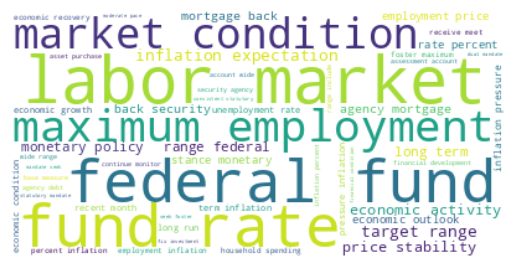

In [5]:
# Generate and plot WordCloud for full corpus
wordcloud = WordCloud(background_color="white").generate(','.join(FOMCWordCloud)) # NB. 'join' method used to convert the documents list to text format
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [42]:
### NUMERIC REPRESENTATION OF CORPUS USING TF-IDF ###

# Form dictionary by mapping word IDs to words
ID2word = corpora.Dictionary(FOMCMinutes)

# Set up Bag of Words and TFIDF
corpus = [ID2word.doc2bow(doc) for doc in FOMCMinutes] # Apply Bag of Words to all documents in corpus
TFIDF = models.TfidfModel(corpus) # Fit TF-IDF model
trans_TFIDF = TFIDF[corpus] # Apply TF-IDF model

# 전체 corpora를 dictionary화한 후 TFIDF를 구해 corpus별 TFIDF를 매칭

In [43]:
### SET UP LDA MODEL ###

SEED = 130 # Set random seed
NUM_topics = 6 # Set number of topics
ALPHA = 0.15 # Set alpha
ETA = 1.25 # Set eta

# Train LDA model using the corpus
lda_model = gensim.models.LdaMulticore(corpus=trans_TFIDF, num_topics=NUM_topics, id2word=ID2word, random_state=SEED, alpha=ALPHA, eta=ETA, passes=100)
lda_model.save('lda_model')
# 비지도학습

In [44]:
### CALCULATE COHERENCE SCORE ###

# Set up coherence model
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=FOMCMinutes, dictionary=ID2word, coherence='c_v')

# Calculate coherence
coherence_lda = coherence_model_lda.get_coherence()
print('-'*50)
print('\nCoherence Score:', coherence_lda)
print('-'*50)

--------------------------------------------------

Coherence Score: 0.5348307275746297
--------------------------------------------------


In [45]:
### GENERATE WEIGHTED TOPIC PROPORTIONS FOR CORPUS ###

para_no = 0 # Set document counter
for para in FOMCTopix:
    TFIDF_para = TFIDF[corpus[para_no]] # Apply TFIDF model to individual minutes documents
    # Generate and store weighted topic proportions for each para
    for topic_weight in lda_model.get_document_topics(TFIDF_para): # List of tuples ("topic number", "topic proportion") for each para, where 'topic_weight' is the (iterating) tuple
        FOMCTopix[para_no].append(FOMCTopix[para_no][1]*topic_weight[1]) # Weights are the second element of the pre-appended list, topic proportions are the second element of each tuple
    para_no += 1

# FOMCTopix: in each para embedding TFIDF_para, calculate topic weight by TFIDF of corpus. After that FOMCTopix = [date, len(para)/cum(para), TFIDF of each topics] of each para

In [47]:
# Show topics

topics = lda_model.print_topics(num_words=15)
for topic in topics:
    print(topic)

(0, '0.007*"inflation" + 0.007*"policy" + 0.007*"member" + 0.006*"security" + 0.006*"fund" + 0.006*"participant" + 0.006*"percent" + 0.006*"appropriate" + 0.006*"range" + 0.006*"monetary" + 0.006*"federal" + 0.006*"target" + 0.005*"agree" + 0.005*"holding" + 0.005*"economic"')
(1, '0.008*"loan" + 0.007*"credit" + 0.005*"business" + 0.005*"remain" + 0.005*"real" + 0.005*"sector" + 0.004*"consumer" + 0.004*"issuance" + 0.004*"bank" + 0.004*"commercial" + 0.004*"spending" + 0.004*"standard" + 0.004*"mortgage" + 0.004*"low" + 0.004*"home"')
(2, '0.013*"joint" + 0.007*"continue" + 0.006*"minute" + 0.006*"reference" + 0.004*"projection" + 0.004*"text" + 0.003*"fomc" + 0.003*"assessment" + 0.002*"converge" + 0.002*"submit" + 0.002*"conjunction" + 0.002*"variable" + 0.002*"represent" + 0.002*"return" + 0.002*"president"')
(3, '0.009*"instruct" + 0.008*"directive" + 0.008*"accordance" + 0.008*"execute" + 0.007*"conclusion" + 0.006*"direct" + 0.005*"transaction" + 0.005*"domestic" + 0.005*"autho

In [39]:
# Form dataframe of weighted topic proportions (paragraphs) - include any chosen topic names
FOMCTopixDF = pd.DataFrame(FOMCTopix, columns=['Date', 'Weight', '1', '2', '3', '4', '5', '6'])

# Aggregate topic mix by minutes documents (weighted sum of paragraphs)
TopixAggDF = pd.pivot_table(FOMCTopixDF, values=['1', '2', '3', '4', '5', '6'], index='Date', aggfunc=np.sum)

# Plot results - select which topics to print and change to accumulated area type _ error
# TopixAggDF.plot(y=['1', '2', '3', '4'], kind='line', use_index=True)

import plotly.graph_objects as go

# Assuming TopixAggDF is your DataFrame

# Create a line graph
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=TopixAggDF.index, y=TopixAggDF['1'], mode='lines', name='1'))
fig.add_trace(go.Scatter(x=TopixAggDF.index, y=TopixAggDF['2'], mode='lines', name='2'))
fig.add_trace(go.Scatter(x=TopixAggDF.index, y=TopixAggDF['3'], mode='lines', name='3'))
fig.add_trace(go.Scatter(x=TopixAggDF.index, y=TopixAggDF['4'], mode='lines', name='4'))
fig.add_trace(go.Scatter(x=TopixAggDF.index, y=TopixAggDF['5'], mode='lines', name='5'))
fig.add_trace(go.Scatter(x=TopixAggDF.index, y=TopixAggDF['6'], mode='lines', name='6'))

# Show the figure
fig.show()

In [17]:
import plotly.graph_objects as go

# Assuming TopixAggDF is your dataframe

fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = TopixAggDF['1'],
                   colorscale = 'Tealrose',
                   showscale = True,
                   cmin = 0,
                   cmax = 0.5),
        dimensions = list([
            dict(range = [0,0.5],
                 label = '1', values = TopixAggDF['1']),
            dict(range = [0,0.5],
                 label = '2', values = TopixAggDF['2']),
            dict(range = [0,0.5],
                 label = '3', values = TopixAggDF['3']),
            dict(range = [0,0.5],
                 label = '4', values = TopixAggDF['4'])
        ])
    )
)
fig.show()

In [ ]:
### PRINT TOPIC WORD CLOUDS ###

topic = 0 # Initialize counter
while topic < NUM_topics:
    # Get topics and frequencies and store in a dictionary structure
    topic_words_freq = dict(lda_model.show_topic(topic, topn=50)) # NB. the 'dict()' constructor builds dictionaries from sequences (lists) of key-value pairs - this is needed as input for the 'generate_from_frequencies' word cloud function
    topic += 1

    # Generate Word Cloud for topic using frequencies
    wordcloud = WordCloud(background_color="white").generate_from_frequencies(topic_words_freq)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [ ]:
### TEST COHERENCE BY VARYING KEY PARAMETERS ###

# Coherence values for varying eta
def compute_coherence_values_ETA(corpus, dictionary, num_topics, seed, alpha, texts, start, limit, step):
    coherence_values = []
    model_list = []
    for eta in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=seed, alpha=alpha, eta=eta/100, passes=100)
        model_list.append(model)
        coherencemodel = gensim.models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values_ETA(corpus=trans_TFIDF, dictionary=ID2word, num_topics=NUM_topics, seed=SEED, alpha=ALPHA, texts=FOMCMinutes, start=115, limit=175, step=5)

# Plot graph of coherence values by varying eta
limit=175; start=115; step=5;
#x = range(start, limit, step)
x_axis = []
for x in range(start, limit, step):
    x_axis.append(x/100)
plt.plot(x_axis, coherence_values)
plt.xlabel("Eta")
plt.ylabel("Coherence score")
plt.legend(("coherence"), loc='best')
plt.show()

In [ ]:
### Coherence values for varying seed
def compute_coherence_values_SEED(corpus, dictionary, alpha, num_topics, eta, texts, start, limit, step):
    coherence_values = []
    model_list = []
    for seed in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, alpha=alpha, num_topics=num_topics, eta=eta, random_state=seed, passes=100)
        model_list.append(model)
        coherencemodel = gensim.models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values_SEED(corpus=trans_TFIDF, dictionary=ID2word, alpha=ALPHA, num_topics=NUM_topics, eta=ETA, texts=FOMCMinutes, start=60, limit=165, step=5)

# Plot graph of coherence values by varying seed
limit=165; start=60; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Random Seed")
plt.ylabel("Coherence score")
plt.legend(("coherence"), loc='best')
plt.show()

In [ ]:
### Coherence values for varying alpha
def compute_coherence_values_ALPHA(corpus, dictionary, num_topics, seed, eta, texts, start, limit, step):
    coherence_values = []
    model_list = []
    for alpha in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=seed, eta=eta, alpha=alpha/20, passes=100)
        model_list.append(model)
        coherencemodel = gensim.models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values_ALPHA(dictionary=ID2word, corpus=trans_TFIDF, num_topics=NUM_topics, seed=SEED, eta=ETA, texts=FOMCMinutes, start=1, limit=20, step=1)

# Plot graph of coherence values by varying alpha
limit=20; start=1; step=1;
x_axis = []
for x in range(start, limit, step):
    x_axis.append(x/20)
plt.plot(x_axis, coherence_values)
plt.xlabel("Alpha")
plt.ylabel("Coherence score")
plt.legend(("coherence"), loc='best')
plt.show()

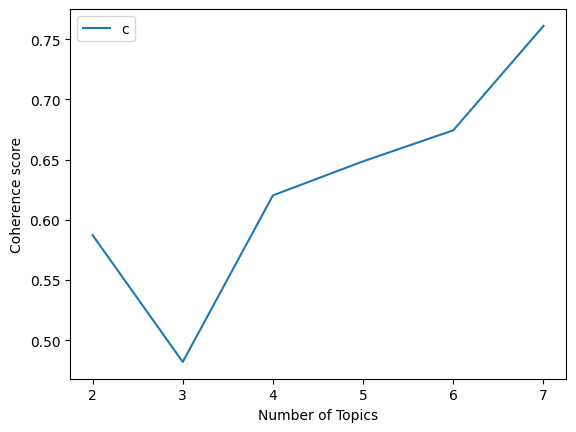

In [19]:
# Coherence values for varying number of topics
def compute_coherence_values_TOPICS(corpus, dictionary, alpha, seed, eta, texts, start, limit, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, alpha=alpha, num_topics=num_topics, random_state=seed, eta=eta, passes=100)
        model_list.append(model)
        coherencemodel = gensim.models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values_TOPICS(corpus=trans_TFIDF, dictionary=ID2word, alpha=ALPHA, seed=SEED, eta=ETA, texts=FOMCMinutes, start=2, limit=8, step=1)

# Plot graph of coherence values by varying number of topics
limit=8; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence"), loc='best')
plt.show()